In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time

# Instructions for Use

1. Rename hB/hG/hS to h
2. Find rows of dataset that have unique combinations of h, rM, and C_prime
3. Find values of hB and rM for which there are 2 or more C_prime values (indicating bistability)
4. For hB and rM combinations that promote bistability, create a dataset of all runs with those combinations called 'bistable'. Add column 'Bistable' to dataset and populate it with '1'
5. Add column 'Bistable' to larger, equilibria dataset and populate it with '0'
6. Match and replace rows in larger 'equilibria' dataset with columns in smaller 'bistable' dataset. The resultant dataset (called 'equilibria_bi') has a column 'Bistable' with two values (1 = bistability and 0 = no bistability)
7. Using for loop, assign values to new column, 'heatmap_values,' according to values in 'color_col' and 'Bistable' columns
8. Round h and rM for heat map plotting

In [185]:
def heatmap_plot(equilibria):

    # STEP 1: Rename hB/hG/hS to h --------------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    if max(equilibria['hB'] > 0) and max(equilibria['hG'] == 0) and max(equilibria['hS'] == 0):
        equilibria = equilibria.rename(columns={'hB': 'h'})
    elif max(equilibria['hG'] > 0) and max(equilibria['hB'] == 0) and max(equilibria['hS'] == 0):
        equilibria = equilibria.rename(columns={'hG': 'h'})
    elif max(equilibria['hS'] > 0) and max(equilibria['hB'] == 0) and max(equilibria['hG'] == 0):
        equilibria = equilibria.rename(columns={'hS': 'h'})
    elif max(equilibria['hB'] > 0) and max(equilibria['hG'] > 0) and max(equilibria['hS'] == 0):
        equilibria = equilibria.rename(columns={'hB': 'h'})
    elif max(equilibria['hB'] > 0) and max(equilibria['hS'] > 0) and max(equilibria['hG'] == 0):
        equilibria = equilibria.rename(columns={'hB': 'h'})
    elif max(equilibria['hG'] > 0) and max(equilibria['hS']) > 0 and max(equilibria['hB'] == 0):
        equilibria = equilibria.rename(columns={'hB': 'h'})
    elif max(equilibria['hB'] > 0) and max(equilibria['hG'] > 0) and max(equilibria['hS'] > 0):
        equilibria = equilibria.rename(columns={'hB': 'h'})
    elif max(equilibria['hB'] == 0) and max(equilibria['hG'] == 0) and max(equilibria['hS'] == 0):
        equilibria = equilibria.rename(columns={'hB': 'h'})

    
    # STEP 2: Find rows of dataset that have unique combinations of h, rM, and C_prime ----------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    equilibria_C = equilibria[['rM', 'h', 'C_prime', 'M_prime', 'T_prime', 'F_prime', 'B_prime']]
    equilibria_C.loc[:, ('C_prime')] = equilibria_C.loc[:, ('C_prime')].round(2)
    equilibria_C = equilibria_C.drop_duplicates(subset = ['h', 'rM', 'C_prime'])
    
    
    
    # STEP 3: Find values of h and rM for which there are 2 or more C_prime values (indicating bistability)--------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    plot_df = []
    
    h_val = np.linspace(0,1,11)
    rM_val = np.linspace(0,1,11)
        
    for rM in rM_val:
    
        for h in h_val:
    
            subset = equilibria_C[equilibria_C['rM'] == rM]
            subset = subset[subset['h'] == h]
            
            if subset.shape[0] >= 2:
                plot_df.append(subset)

    if len(plot_df) > 0:
        C_plot = pd.concat(plot_df, ignore_index=True)

    if len(plot_df) == 0:
        C_plot = []
    
    
    
    # STEP 4: For h and rM combinations that promote bistability, create a dataset of all runs with those combinations called 'bistable'. 
    # Add column 'Bistable' to dataset and populate it with '1'----------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    bistable = []
    array = list(range(len(C_plot)))
    
    for i in array:
    
        rM_val = list(C_plot['rM'])[i]
        h_val = list(C_plot['h'])[i]
    
        equilibria_bistable = equilibria[(equilibria['rM'] == rM_val) & (equilibria['h'] == h_val)]
    
        bistable.append(equilibria_bistable)

    if len(bistable) > 0:
        bistable = pd.concat(bistable, ignore_index=False)
    
        bistable['Bistable'] = [1]*len(bistable)

    if len(bistable) == 0:
        bistable = []
    
    
    
    # STEP 5: Add column 'Bistable' to larger, equilibria dataset and populate it with '0'-------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    equilibria['Bistable'] = [0]*len(equilibria)

    if len(bistable) > 0:
        equilibria.loc[bistable.index] = bistable

    if len(bistable) == 0:
        equilibria = equilibria
    
    equilibria_bi = equilibria
    
    
    
    # STEP 6: Match and replace rows in larger 'equilibria' dataset with columns in smaller 'bistable' dataset.----------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    equilibria_bi.loc[:, ('C_prime')] = equilibria_bi.loc[:, ('C_prime')].round(2)
    equilibria_bi = equilibria_bi.drop_duplicates(subset = ['h', 'rM']) #note you removed C_prime here

    
    
    # STEP 7: Using for loop, assign values to new column, 'heatmap_values,' according to values in 'color_col' and 'Bistable' columns.----
    #--------------------------------------------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    equilibria_bi = equilibria_bi.reset_index()
    
    equilibria_bi['heatmap_values'] = [1]*len(equilibria_bi)
    
    array = list(range(len(equilibria_bi)))
    
    for i in array:

        #Bistable
        if (equilibria_bi.loc[i, ('color_col')] == 'allC') & (equilibria_bi.loc[i, ('Bistable')] == 1):
            equilibria_bi.loc[i, ('heatmap_values')] = 9
            
        elif (equilibria_bi.loc[i, ('color_col')] == 'allM') & (equilibria_bi.loc[i, ('Bistable')] == 1):
            equilibria_bi.loc[i, ('heatmap_values')] = 9

        elif (equilibria_bi.loc[i, ('color_col')] == 'allT') & (equilibria_bi.loc[i, ('Bistable')] == 1):
            equilibria_bi.loc[i, ('heatmap_values')] = 9

        elif (equilibria_bi.loc[i, ('color_col')] == 'allF') & (equilibria_bi.loc[i, ('Bistable')] == 1):
            equilibria_bi.loc[i, ('heatmap_values')] = 9

        elif (equilibria_bi.loc[i, ('color_col')] == 'mostlyC') & (equilibria_bi.loc[i, ('Bistable')] == 1):
            equilibria_bi.loc[i, ('heatmap_values')] = 9
            
        elif (equilibria_bi.loc[i, ('color_col')] == 'mostlyC_noT') & (equilibria_bi.loc[i, ('Bistable')] == 1):
            equilibria_bi.loc[i, ('heatmap_values')] = 9

        elif (equilibria_bi.loc[i, ('color_col')] == 'mostlyM') & (equilibria_bi.loc[i, ('Bistable')] == 1):
            equilibria_bi.loc[i, ('heatmap_values')] = 9
            
        elif (equilibria_bi.loc[i, ('color_col')] == 'mostlyM_noT') & (equilibria_bi.loc[i, ('Bistable')] == 1):
            equilibria_bi.loc[i, ('heatmap_values')] = 9

        elif (equilibria_bi.loc[i, ('color_col')] == 'mostlyT') & (equilibria_bi.loc[i, ('Bistable')] == 1):
            equilibria_bi.loc[i, ('heatmap_values')] = 9

        elif (equilibria_bi.loc[i, ('color_col')] == 'other') & (equilibria_bi.loc[i, ('Bistable')] == 1):
            equilibria_bi.loc[i, ('heatmap_values')] = 9


        #Specific Conditions
        elif (equilibria_bi.loc[i, ('color_col')] == 'allC') & (equilibria_bi.loc[i, ('Bistable')] == 0):
            equilibria_bi.loc[i, ('heatmap_values')] = 1

        elif (equilibria_bi.loc[i, ('color_col')] == 'mostlyC') & (equilibria_bi.loc[i, ('Bistable')] == 0):
            equilibria_bi.loc[i, ('heatmap_values')] = 2
            
        elif (equilibria_bi.loc[i, ('color_col')] == 'mostlyC_noT') & (equilibria_bi.loc[i, ('Bistable')] == 0):
            equilibria_bi.loc[i, ('heatmap_values')] = 2
            
        elif (equilibria_bi.loc[i, ('color_col')] == 'allM') & (equilibria_bi.loc[i, ('Bistable')] == 0):
            equilibria_bi.loc[i, ('heatmap_values')] = 3

        elif (equilibria_bi.loc[i, ('color_col')] == 'mostlyM') & (equilibria_bi.loc[i, ('Bistable')] == 0):
            equilibria_bi.loc[i, ('heatmap_values')] = 4

        elif (equilibria_bi.loc[i, ('color_col')] == 'mostlyM_noT') & (equilibria_bi.loc[i, ('Bistable')] == 0):
            equilibria_bi.loc[i, ('heatmap_values')] = 4        

        elif (equilibria_bi.loc[i, ('color_col')] == 'allT') & (equilibria_bi.loc[i, ('Bistable')] == 0):
            equilibria_bi.loc[i, ('heatmap_values')] = 5
            
        elif (equilibria_bi.loc[i, ('color_col')] == 'mostlyT') & (equilibria_bi.loc[i, ('Bistable')] == 0):
            equilibria_bi.loc[i, ('heatmap_values')] = 6

        elif (equilibria_bi.loc[i, ('color_col')] == 'allF') & (equilibria_bi.loc[i, ('Bistable')] == 0):
            equilibria_bi.loc[i, ('heatmap_values')] = 7
        
        elif (equilibria_bi.loc[i, ('color_col')] == 'other') & (equilibria_bi.loc[i, ('Bistable')] == 0):
            equilibria_bi.loc[i, ('heatmap_values')] = 8



    # STEP 8: Round h and rM for heat map plotting----------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------------------

    equilibria_bi.loc[:, ('h')] = equilibria_bi.loc[:, ('h')].round(2)
    equilibria_bi.loc[:, ('rM')] = equilibria_bi.loc[:, ('rM')].round(2)

    return(equilibria_bi)

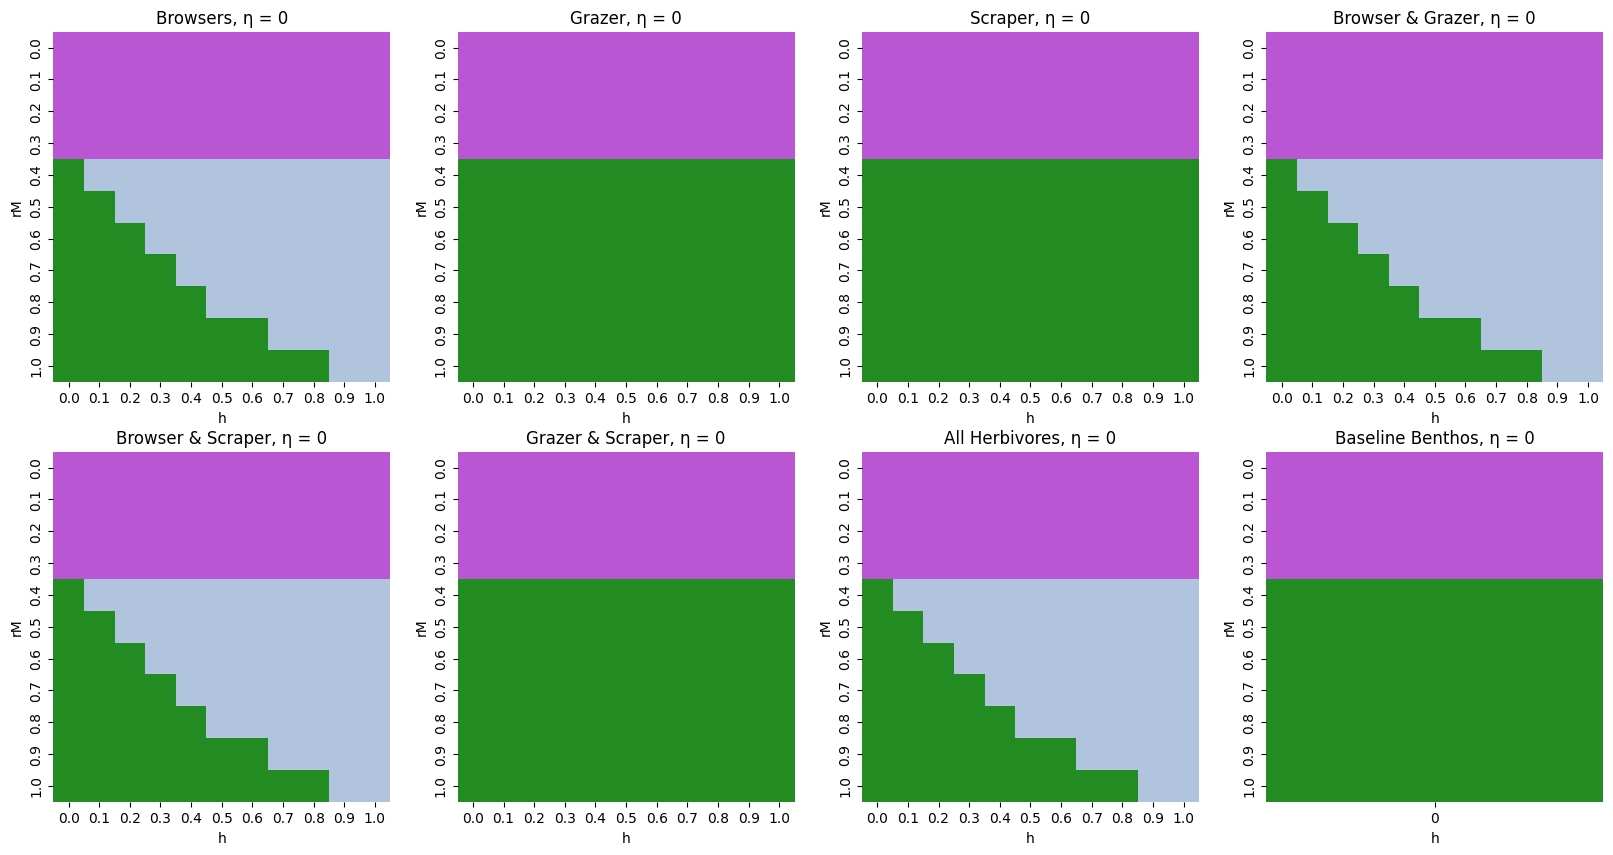

In [267]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
my_colors = ['mediumorchid', 'plum', 'forestgreen','mediumseagreen', 'peru', 'peachpuff', 'gray', 'k', 'lightsteelblue']

#BROWSERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_Browsers_AltSS_μM12_hrM_η0_030825')

Heatmap_Browsers_AltSS_μM12_hrM_η0_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_Browsers_AltSS_μM12_hrM_η0_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[0,0], cbar=False)
axes[0,0].set_title('Browsers, η = 0');



#GRAZERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_Grazer_AltSS_μM12_hrM_η0_030825')

Heatmap_Grazer_AltSS_μM12_hrM_η0_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_Grazer_AltSS_μM12_hrM_η0_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[0,1], cbar=False)
axes[0,1].set_title('Grazer, η = 0');



#SCRAPERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_Scraper_AltSS_μM12_hrM_η0_030825')

Heatmap_Scraper_AltSS_μM12_hrM_η0_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_Scraper_AltSS_μM12_hrM_η0_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[0,2], cbar=False)
axes[0,2].set_title('Scraper, η = 0');


#BROWSERS & GRAZERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_BrowserGrazer_AltSS_μM12_hrM_η0_030825')

Heatmap_BrowserGrazer_AltSS_μM12_hrM_η0_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_BrowserGrazer_AltSS_μM12_hrM_η0_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

heatmap = sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[0,3], cbar=False)
#c_bar = heatmap.collections[0].colorbar
#c_bar.set_ticks([1,2,3,4,5,6,7,8,9])
#c_bar.set_ticklabels(['allC', 'mostlyC', 'allM', 'mostlyM', 'allT', 'mostlyT', 'allF', 'other','bistable'])
axes[0,3].set_title('Browser & Grazer, η = 0');



#BROWSERS & SCRAPERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_BrowserScraper_AltSS_μM12_hrM_η0_030825')

Heatmap_BrowserScraper_AltSS_μM12_hrM_η0_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_BrowserScraper_AltSS_μM12_hrM_η0_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[1,0], cbar=False)
axes[1,0].set_title('Browser & Scraper, η = 0');



#GRAZERS & SCRAPERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_GrazerScraper_AltSS_μM12_hrM_η0_030825')

Heatmap_GrazerScraper_AltSS_μM12_hrM_η0_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_GrazerScraper_AltSS_μM12_hrM_η0_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[1,1], cbar=False)
axes[1,1].set_title('Grazer & Scraper, η = 0');


#ALL HERBIVORES---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_AllHerbivores_AltSS_μM12_hrM_η0_030825')

Heatmap_AllHerbivores_AltSS_μM12_hrM_η0_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_AllHerbivores_AltSS_μM12_hrM_η0_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[1,2], cbar=False)
axes[1,2].set_title('All Herbivores, η = 0'); 



#BASELINE BENTHOS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_BaselineBenthos_AltSS_μM12_hrM_η0_030825')

Heatmap_BaselineBenthos_AltSS_μM12_hrM_η0_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_BaselineBenthos_AltSS_μM12_hrM_η0_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[1,3], cbar=False)
axes[1,3].set_title('Baseline Benthos, η = 0'); 


#fig.savefig('Covarying h and rM_η=0');

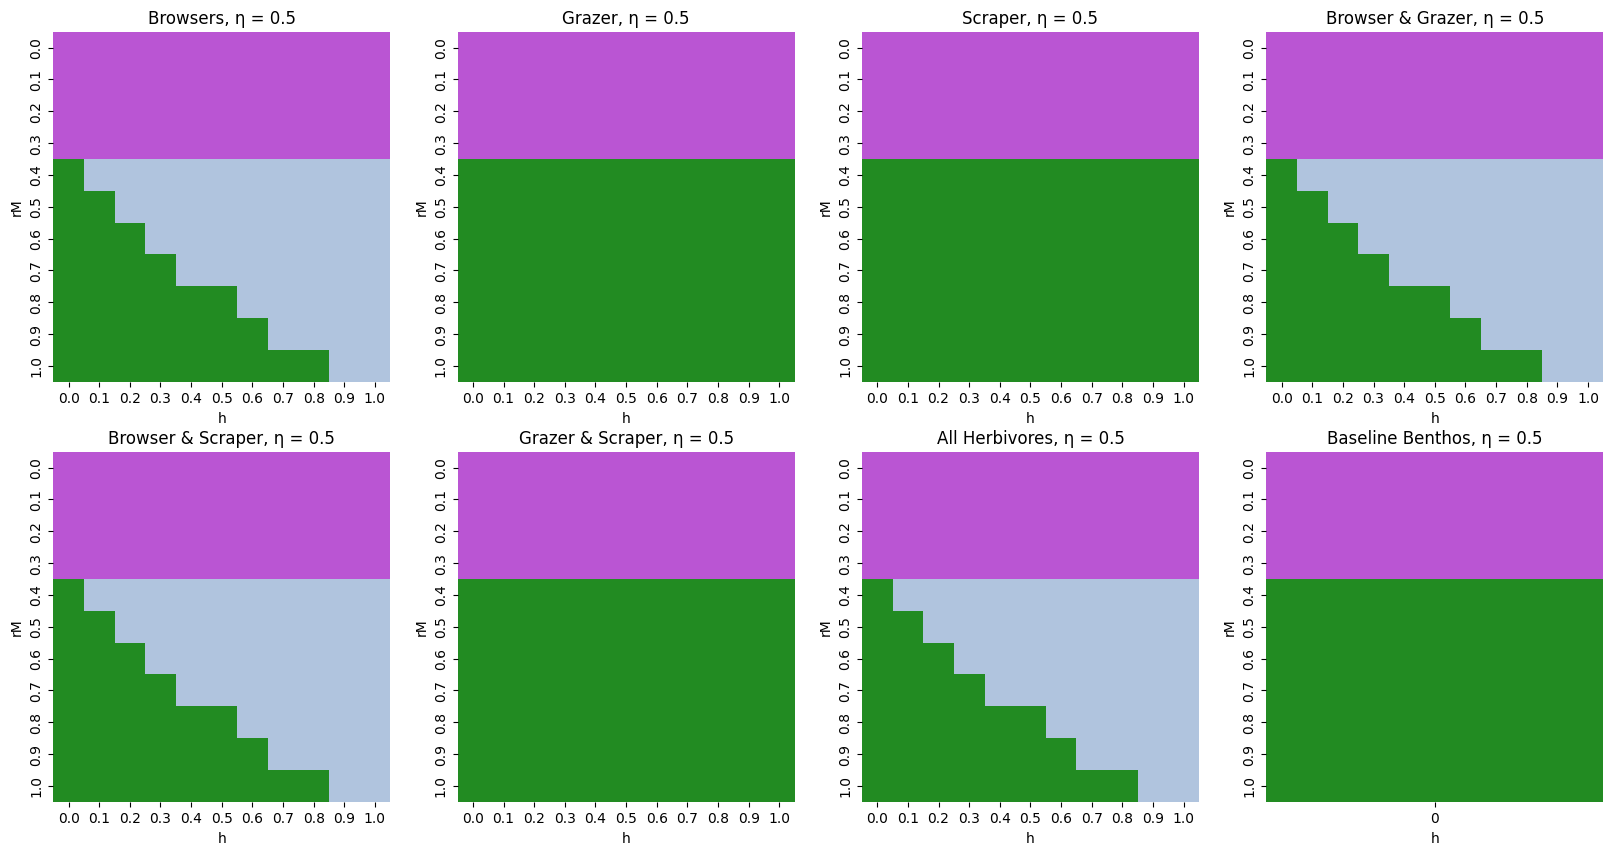

In [257]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
my_colors = ['mediumorchid', 'plum', 'forestgreen','mediumseagreen', 'peru', 'peachpuff', 'gray', 'k', 'lightsteelblue']

#BROWSERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_Browsers_AltSS_μM12_hrM_η05_030825')

Heatmap_Browsers_AltSS_μM12_hrM_η05_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_Browsers_AltSS_μM12_hrM_η05_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[0,0], cbar=False)
axes[0,0].set_title('Browsers, η = 0.5');



#GRAZERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_Grazer_AltSS_μM12_hrM_η05_030825')

Heatmap_Grazer_AltSS_μM12_hrM_η05_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_Grazer_AltSS_μM12_hrM_η05_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[0,1], cbar=False)
axes[0,1].set_title('Grazer, η = 0.5');



#SCRAPERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_Scraper_AltSS_μM12_hrM_η05_030825')

Heatmap_Scraper_AltSS_μM12_hrM_η05_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_Scraper_AltSS_μM12_hrM_η05_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[0,2], cbar=False)
axes[0,2].set_title('Scraper, η = 0.5');


#BROWSERS & GRAZERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_BrowserGrazer_AltSS_μM12_hrM_η05_030825')

Heatmap_BrowserGrazer_AltSS_μM12_hrM_η05_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_BrowserGrazer_AltSS_μM12_hrM_η05_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[0,3], cbar=False)
#c_bar = ax.collections[0].colorbar
#c_bar.set_ticks([1,2,3,4,5,6,7,8,9])
#c_bar.set_ticklabels(['allC', 'mostlyC', 'allM', 'mostlyM', 'allT', 'mostlyT', 'allF', 'other','bistable'])
axes[0,3].set_title('Browser & Grazer, η = 0.5');



#BROWSERS & SCRAPERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_BrowserScraper_AltSS_μM12_hrM_η05_030825')

Heatmap_BrowserScraper_AltSS_μM12_hrM_η05_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_BrowserScraper_AltSS_μM12_hrM_η05_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[1,0], cbar=False)
axes[1,0].set_title('Browser & Scraper, η = 0.5');



#GRAZERS & SCRAPERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_GrazerScraper_AltSS_μM12_hrM_η05_030825')

Heatmap_GrazerScraper_AltSS_μM12_hrM_η05_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_GrazerScraper_AltSS_μM12_hrM_η05_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[1,1], cbar=False)
axes[1,1].set_title('Grazer & Scraper, η = 0.5');


#ALL HERBIVORES---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_AllHerbivores_AltSS_μM12_hrM_η05_030825')

Heatmap_AllHerbivores_AltSS_μM12_hrM_η05_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_AllHerbivores_AltSS_μM12_hrM_η05_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[1,2], cbar=False)
axes[1,2].set_title('All Herbivores, η = 0.5'); 



#BASELINE BENTHOS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_BaselineBenthos_AltSS_μM12_hrM_η05_030825')

Heatmap_BaselineBenthos_AltSS_μM12_hrM_η05_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_BaselineBenthos_AltSS_μM12_hrM_η05_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[1,3], cbar=False)
axes[1,3].set_title('Baseline Benthos, η = 0.5'); 


#fig.savefig('Covarying h and rM_η=05');

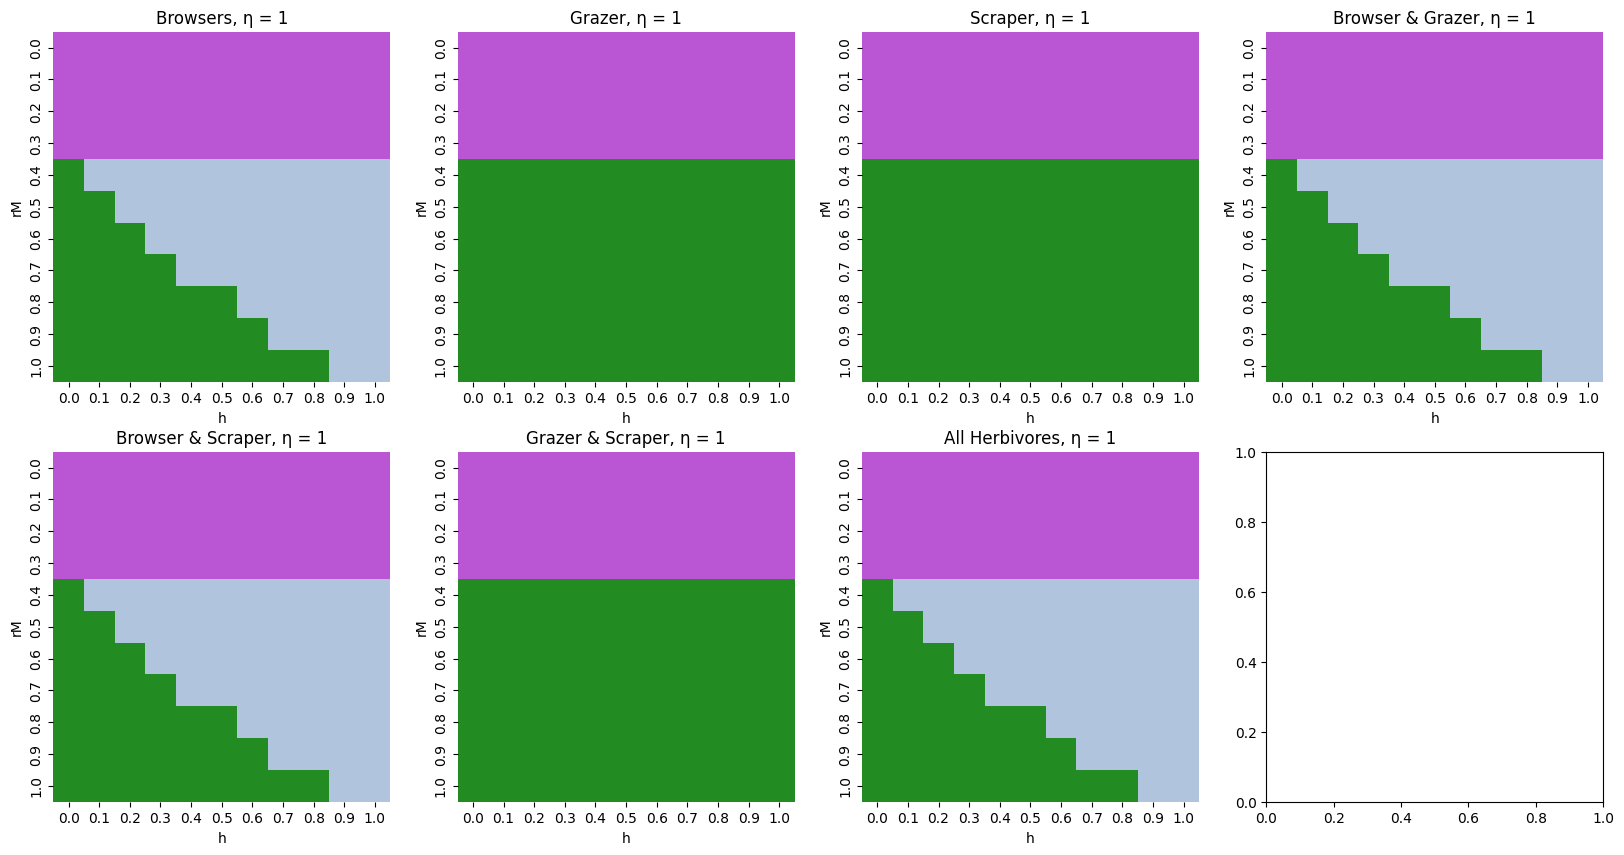

In [269]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
my_colors = ['mediumorchid', 'plum', 'forestgreen','mediumseagreen', 'peru', 'peachpuff', 'gray', 'k', 'lightsteelblue']

#BROWSERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_Browsers_AltSS_μM12_hrM_η1_030825')

Heatmap_Browsers_AltSS_μM12_hrM_η1_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_Browsers_AltSS_μM12_hrM_η1_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[0,0], cbar=False)
axes[0,0].set_title('Browsers, η = 1');



#GRAZERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_Grazer_AltSS_μM12_hrM_η1_030825')

Heatmap_Grazer_AltSS_μM12_hrM_η1_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_Grazer_AltSS_μM12_hrM_η1_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[0,1], cbar=False)
axes[0,1].set_title('Grazer, η = 1');



#SCRAPERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_Scraper_AltSS_μM12_hrM_η1_030825')

Heatmap_Scraper_AltSS_μM12_hrM_η1_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_Scraper_AltSS_μM12_hrM_η1_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[0,2], cbar=False)
axes[0,2].set_title('Scraper, η = 1');


#BROWSERS & GRAZERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_BrowserGrazer_AltSS_μM12_hrM_η1_030825')

Heatmap_BrowserGrazer_AltSS_μM12_hrM_η1_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_BrowserGrazer_AltSS_μM12_hrM_η1_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[0,3], cbar=False)
#c_bar = ax.collections[0].colorbar
#c_bar.set_ticks([1,2,3,4,5,6,7,8,9])
#c_bar.set_ticklabels(['allC', 'mostlyC', 'allM', 'mostlyM', 'allT', 'mostlyT', 'allF', 'other','bistable'])
axes[0,3].set_title('Browser & Grazer, η = 1');



#BROWSERS & SCRAPERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_BrowserScraper_AltSS_μM12_hrM_η1_030825')

Heatmap_BrowserScraper_AltSS_μM12_hrM_η1_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_BrowserScraper_AltSS_μM12_hrM_η1_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[1,0], cbar=False)
axes[1,0].set_title('Browser & Scraper, η = 1');



#GRAZERS & SCRAPERS---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_GrazerScraper_AltSS_μM12_hrM_η1_030825')

Heatmap_GrazerScraper_AltSS_μM12_hrM_η1_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_GrazerScraper_AltSS_μM12_hrM_η1_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[1,1], cbar=False)
axes[1,1].set_title('Grazer & Scraper, η = 1');


#ALL HERBIVORES---------------------------------------
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_AllHerbivores_AltSS_μM12_hrM_η1_030825')

Heatmap_AllHerbivores_AltSS_μM12_hrM_η1_030825 = heatmap_plot(equilibria = equilibria)

heatmap_df = (
    Heatmap_AllHerbivores_AltSS_μM12_hrM_η1_030825
    .pivot(index="rM", columns="h", values="heatmap_values"))

sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[1,2], cbar=False)
axes[1,2].set_title('All Herbivores, η = 1'); 


#BASELINE BENTHOS---------------------------------------
#equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_BaselineBenthos_AltSS_μM12_hrM_η1_030825')

#Heatmap_BaselineBenthos_AltSS_μM12_hrM_η1_030825 = heatmap_plot(equilibria = equilibria)

#heatmap_df = (
 #   Heatmap_BaselineBenthos_AltSS_μM12_hrM_η1_030825
  #  .pivot(index="rM", columns="h", values="heatmap_values"))

#sns.heatmap(heatmap_df, annot=False, cmap=my_colors, vmin=1, vmax=9, ax=axes[1,3], cbar=False)
#axes[1,3].set_title('Baseline Benthos, η = 1'); 


#fig.savefig('Covarying h and rM_η=1');

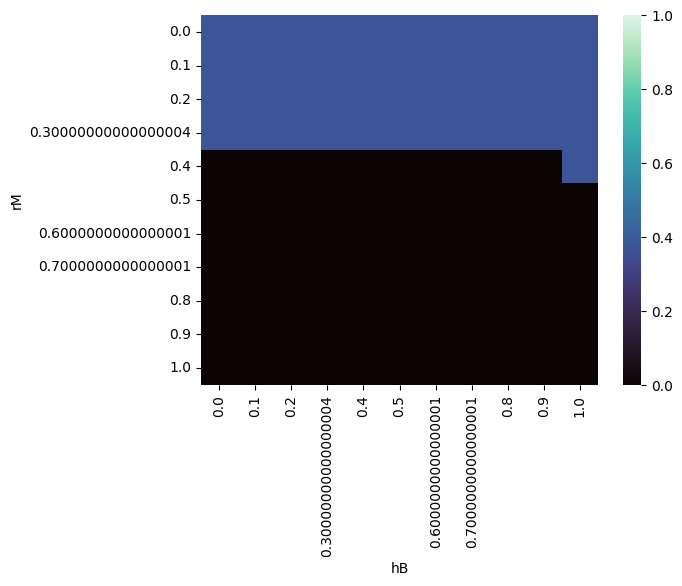

In [34]:
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/Co-varying h & rM at 3 levels of  η_last updated 03-11-2025/equilibria_AllHerbivores_AltSS_μM12_hrM_η1_030825')

equilibria = equilibria.drop_duplicates(subset = ['hB', 'rM'])

#equilibria

heatmap_df = (
    equilibria
    .pivot(index="rM", columns="hB", values= 'B_prime'))

sns.heatmap(heatmap_df, annot=False, cmap='mako', vmin = 0, vmax = 1);
#axes[1,2].set_title('Browsers, η = 1'); 

In [11]:
#NOTESSSSSSSSSS
#I only searched for bistability in relation to coral cover
#I think you mislabeled your steps - check them